In [1]:
%load_ext autoreload
%autoreload 2
import kagglehub
import pandas as pd



path = kagglehub.dataset_download("taweilo/wine-quality-dataset-balanced-classification")
print("Path to dataset files:", path)
wine_df = pd.read_csv(f"{path}/wine_data.csv")
wine_df.describe()

Path to dataset files: /home/lotanamit5/.cache/kagglehub/datasets/taweilo/wine-quality-dataset-balanced-classification/versions/1


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000
mean,9.797079,0.774796,0.793870,31.289348,0.200245,129.442333,229.008762,1.009972,3.158712,1.020641,11.291716,6.000000
std,2.413919,0.365015,0.384833,19.015391,0.124933,77.167262,100.183265,0.012032,0.171371,0.408304,1.182198,2.000048
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,7.600000,0.430000,0.410000,9.800000,0.072000,45.000000,150.000000,0.997417,3.030000,0.620000,10.400000,4.000000
50%,10.000000,0.830000,0.870000,37.600000,0.205000,145.800000,240.500000,1.012200,3.150000,1.080000,11.300000,6.000000
75%,11.800000,1.080000,1.110000,46.800000,0.298000,194.325000,311.625000,1.019840,3.270000,1.360000,12.200000,8.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


In [14]:
from missingness import MissingnessParamsGenerator, apply_missingness
from missing_clf import classify_missing_values
from tqdm import tqdm

results = []

for i, params in enumerate(tqdm(MissingnessParamsGenerator(list(wine_df.columns), initial_seed=42, n_experiments=100), desc="Experiments")):
    modified_df = apply_missingness(wine_df, params)
    metrics = classify_missing_values(modified_df, params.target_feature, seed=params.random_state)
    results.append({**params, **metrics})

results = pd.DataFrame(results)
results.to_csv("results.csv", index=False)
results


Experiments:   0%|          | 0/100 [00:00<?, ?it/s]

Experiments: 100%|██████████| 100/100 [00:59<00:00,  1.69it/s]


,mechanism,strategy,random_state,target_feature,missing_rate,condition_feature,acc,f1,recall,precision,fbeta1,fbeta9
0,MNAR,logistic,54886,alcohol,0.723753,chlorides,0.634747,0.655486,0.694944,0.620268,0.620928,0.651602
1,MAR,range_condition,912756,total_sulfur_dioxide,0.146467,density,0.777286,0.803129,0.908555,0.719626,0.721111,0.793464
2,MNAR,logistic,327069,chlorides,0.875928,quality,0.532650,0.535172,0.537967,0.532406,0.532460,0.534880
3,MAR,double_threshold,421909,quality,0.246724,"[quality, sulphates]",0.864952,0.867925,0.884615,0.851852,0.852164,0.866209
4,MCAR,none,156730,quality,0.118450,alcohol,0.491113,0.495101,0.498684,0.491569,0.491639,0.494728
...,...,...,...,...,...,...,...,...,...,...,...,...
95,MNAR,basic,70640,citric_acid,0.430094,volatile_acidity,0.656716,0.696680,0.788471,0.624033,0.625324,0.688269
96,MNAR,logistic,306955,density,0.793693,chlorides,0.490938,0.494862,0.498805,0.490980,0.491057,0.494451
97,MCAR,none,854882,total_sulfur_dioxide,0.700697,pH,0.497368,0.502086,0.506842,0.497417,0.497509,0.501591
98,MCAR,none,178031,fixed_acidity,0.527462,residual_sugar,0.495801,0.493761,0.491770,0.495767,0.495727,0.493970


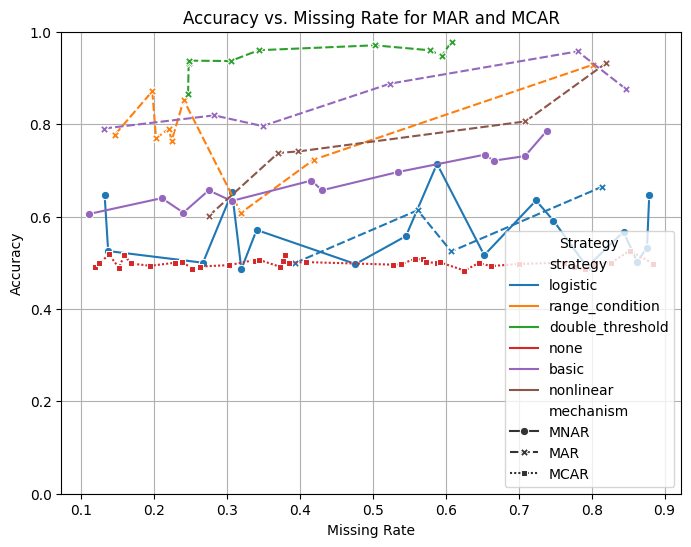

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter data to include only MAR & MCAR with the 'acc' metric
# df_filtered = results[(results["mechanism"].isin(["MAR", "MCAR"]))]

# Plot with seaborn
plt.figure(figsize=(8, 6))
sns.lineplot(
    data=results, 
    x="missing_rate", 
    y="acc", 
    hue="strategy", 
    style="mechanism",  # Different line styles for MAR and MCAR
    markers=True, 
    dashes=True
)

# Formatting
plt.xlabel("Missing Rate")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Missing Rate for MAR and MCAR")
plt.ylim(0, 1)  # Ensure the y-axis stays within [0,1]
plt.legend(title="Strategy")
plt.grid(True)

# Show plot
plt.show()

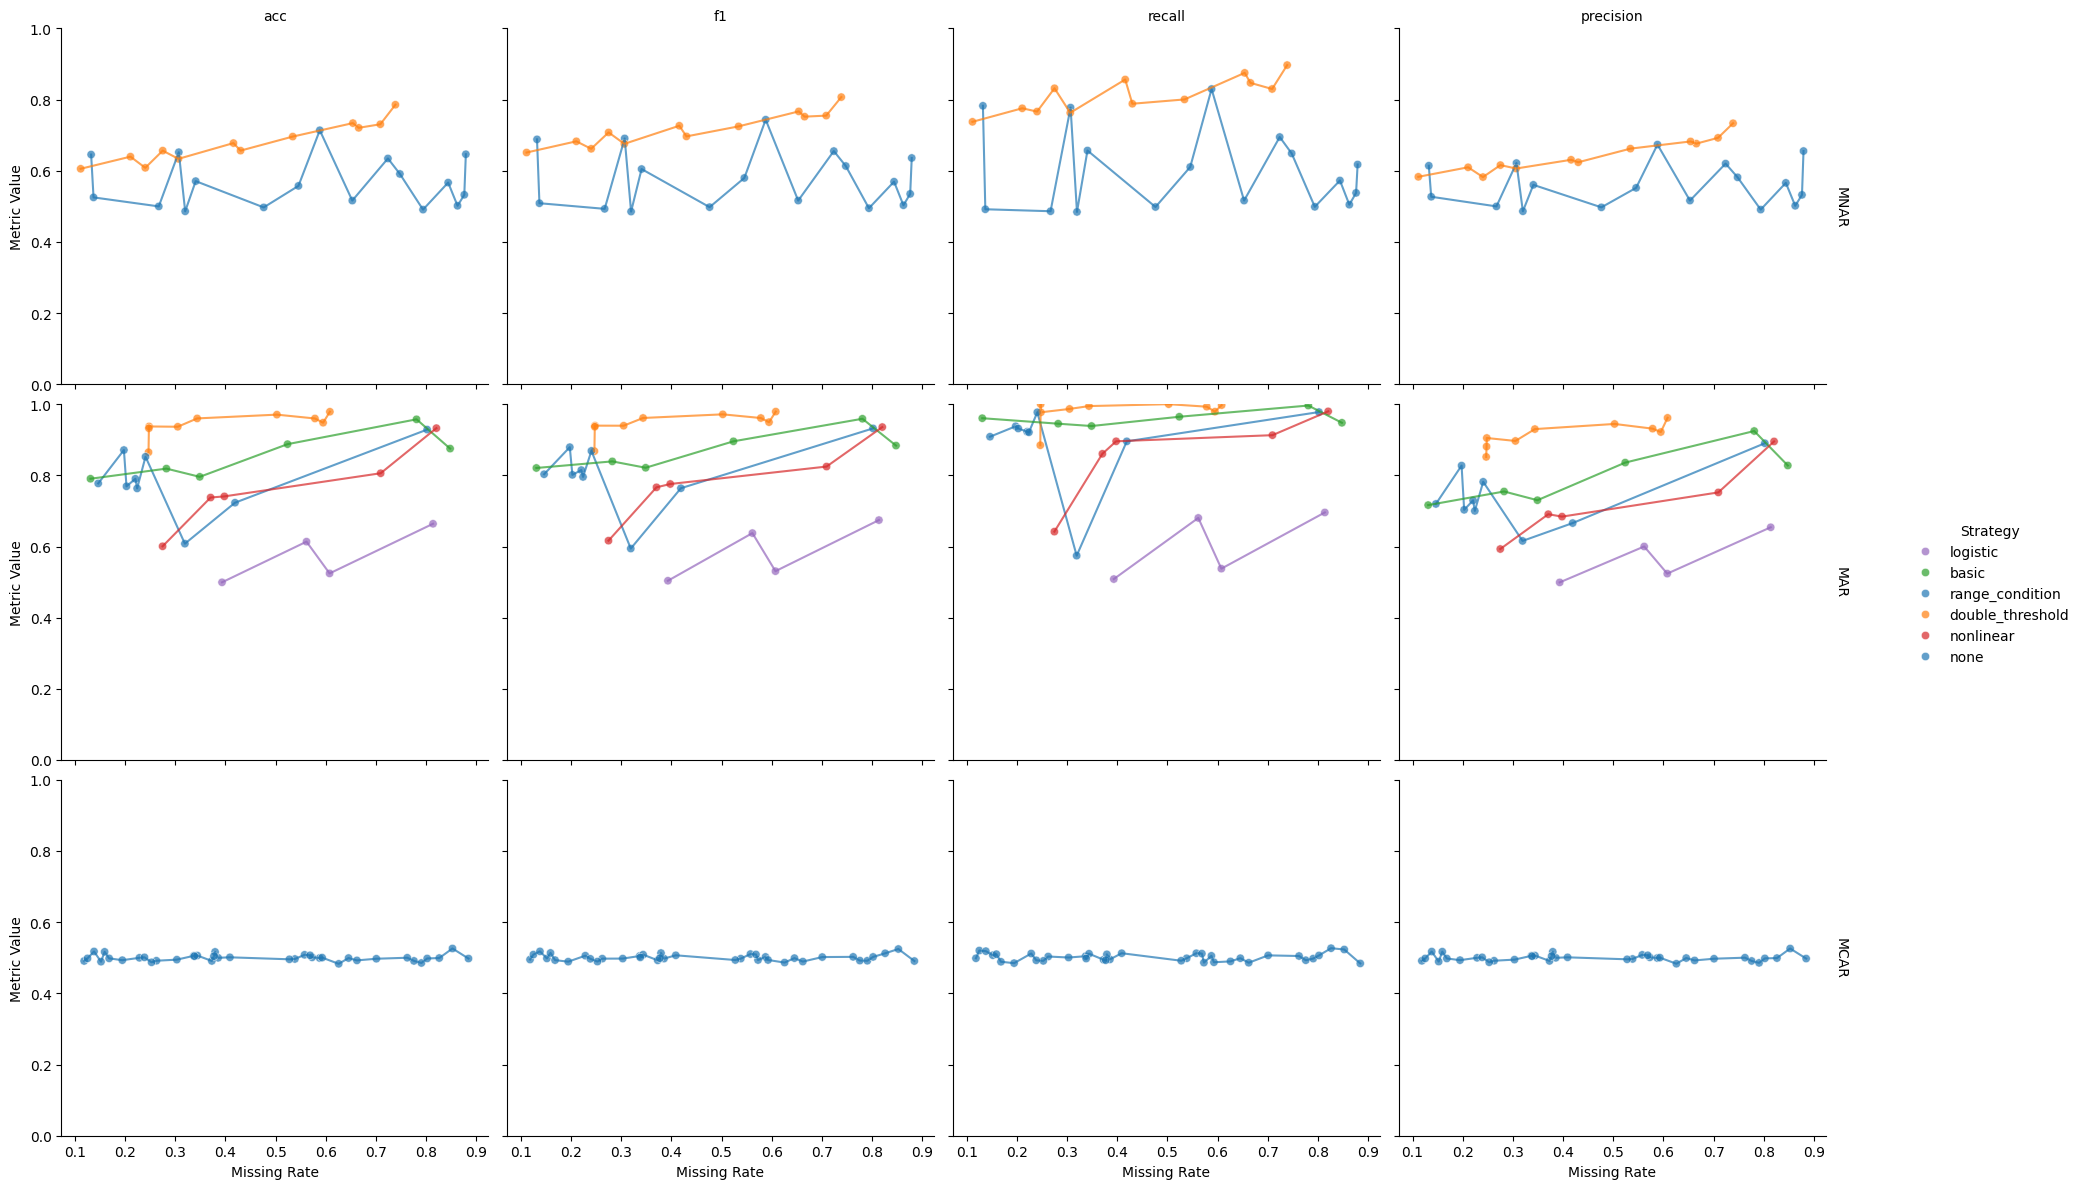

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Melt dataframe to have a single metric column for easy FacetGrid usage
df_melted = results.melt(id_vars=["mechanism", "strategy", "missing_rate"], 
                     value_vars=["acc", "f1", "recall", "precision"],
                     var_name="metric", value_name="value")

# Create a grid of plots: rows = mechanism, columns = metrics
g = sns.FacetGrid(df_melted, row="mechanism", col="metric", 
                  margin_titles=True, height=4, aspect=1.2, sharey=True)

# Map scatter plot and lineplot for visualization
g.map_dataframe(sns.scatterplot, x="missing_rate", y="value", hue="strategy", alpha=0.7)
g.map_dataframe(sns.lineplot, x="missing_rate", y="value", hue="strategy", alpha=0.7, legend=False)

# Adjust aesthetics
g.set_axis_labels("Missing Rate", "Metric Value")
g.set_titles(row_template="{row_name}", col_template="{col_name}")
g.add_legend(title="Strategy")
plt.ylim(0, 1)  # Ensure y-axis stays within bounds
plt.show()


In [17]:
results['true'] = results['mechanism'].apply(lambda x: x == 'MAR')
results['pred'] = results['acc'] > 0.6
print("Accuracy:", (results['true'] == results['pred']).mean())

Accuracy: 0.81


In [5]:
from missingness import MissingnessParamsGenerator, apply_missingness
from tqdm import tqdm

results = []

for i, params in enumerate(tqdm(MissingnessParamsGenerator(list(wine_df.columns), initial_seed=42, n_experiments=1000), desc="Experiments")):
    modified_df = apply_missingness(wine_df, params)
    missing_frac = modified_df.isnull().mean().mean()
    results.append({
        **params,
        'missing_frac': missing_frac
    })

results = pd.DataFrame(results)
results.to_csv("missing_rates_results.csv", index=False)
results


Experiments:  20%|██        | 202/1000 [00:00<00:01, 490.22it/s]/home/lotanamit5/missing_values_project/env/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
Experiments: 100%|██████████| 1000/1000 [00:01<00:00, 506.26it/s]


,mechanism,strategy,random_state,target_feature,missing_rate,condition_feature,missing_frac
0,MNAR,logistic,54886,alcohol,0.723753,chlorides,0.030873
1,MAR,range_condition,912756,total_sulfur_dioxide,0.146467,density,0.004480
2,MNAR,logistic,327069,chlorides,0.875928,quality,0.032913
3,MAR,double_threshold,421909,quality,0.246724,"[quality, sulphates]",0.002056
4,MCAR,none,156730,quality,0.118450,alcohol,0.010044
...,...,...,...,...,...,...,...
995,MCAR,none,461595,density,0.844319,residual_sugar,0.070143
996,MAR,logistic,809359,quality,0.329861,total_sulfur_dioxide,0.010623
997,MAR,double_threshold,741570,total_sulfur_dioxide,0.141035,"[quality, chlorides]",0.002710
998,MNAR,logistic,396308,residual_sugar,0.229094,sulphates,0.012758


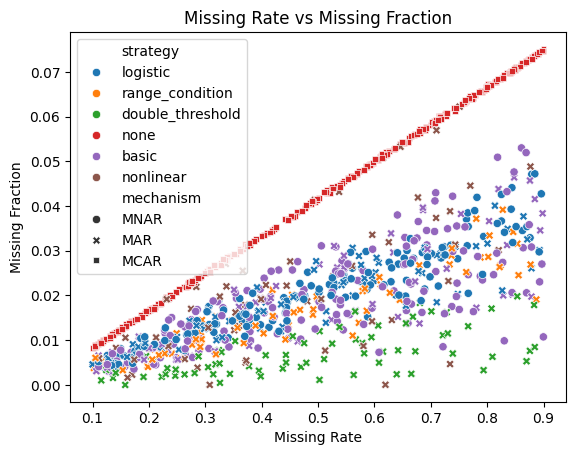

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
df_filtered = results[())]
sns.scatterplot(data=results, x="missing_rate", y="missing_frac", hue="strategy", style="mechanism")
plt.xlabel("Missing Rate")
plt.ylabel("Missing Fraction")
plt.title("Missing Rate vs Missing Fraction")
plt.show()
